# ENEL645 Project - Driver drowsiness detection, section 1
## Model training section
### Group 6


## 0. Services setup
### 0.1 Import libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import random
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### 0.1 Loading google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 0.2 Loading TensorBoard

In [3]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## 1.0 Data preprocessing
### 1.1 See labels

In [4]:
# uncomment if load from local
# dataset_path = 'dataset'
# uncomment if load from google drive
dataset_path = 'gdrive/MyDrive/ENEL-645/Project/Final/dataset'
labels = os.listdir(dataset_path + "/dev")
labels

['open_eyes', 'closed_eyes']

### 1.2 Load dataset with real-time augmentation

In [5]:
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}               
dev_datagen = ImageDataGenerator(rescale = 1./255, 
                                 validation_split = 0.2,
                                 **gen_params
                                 )
test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
dev_data_path = dataset_path + '/dev'
test_data_path = dataset_path + '/test'

train_generator = dev_datagen.flow_from_directory(dev_data_path, 
                                             target_size = (224,224),
                                             batch_size = batch_size, 
                                             color_mode = 'rgb',
                                             class_mode = 'binary',
                                             subset = 'training',
                                             shuffle=True)

val_generator = dev_datagen.flow_from_directory(dev_data_path,
                                           target_size = (224,224),
                                           batch_size = batch_size, 
                                           color_mode = 'rgb',
                                           class_mode = 'binary',
                                           subset = 'validation',
                                           shuffle=True)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### 1.3 Dataset exploring

In [7]:
print(f"Train set labels: {train_generator.labels}")
print(f"Sample image (from batch 1 (X, y) tuple) shape: {train_generator[0][0].shape}")
# To examine a scaling is inplace
print(f"Max value in X from batch 1 first image: {train_generator[0][0].max()}")
# Just to show that there are on-hot encoding inplace
print(f"Encoding sample from batch 1 first 5 images: {train_generator[0][1][:5]}")

Train set labels: [0 0 0 ... 1 1 1]
Sample image (from batch 1 (X, y) tuple) shape: (32, 224, 224, 3)
Max value in X from batch 1 first image: 1.0
Encoding sample from batch 1 first 5 images: [0. 1. 1. 1. 0.]


### 1.4 Displaying some of the images

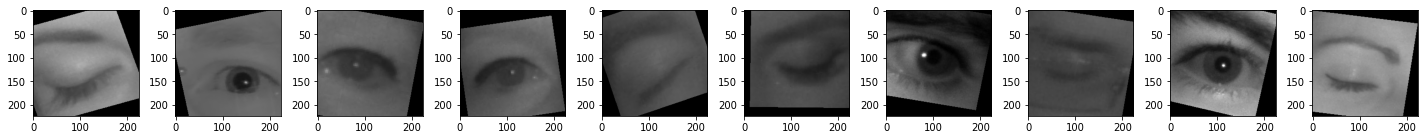

In [8]:
%matplotlib inline

def plot_imgs():
    item_files = train_generator[0][0][:10]
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(item_files):
        plt.subplot(10, 10, i+1)
        plt.tight_layout()         
        plt.imshow(image, cmap="gray") 

plot_imgs()

## 2.0 Build or load models

### 2.1 Load Mobilenet model (transfer learning)

Since we are using transfer learning to help us attain a more accurate result, we then download the pre-trained mobilenet model.

mobile net is also light weight with less number of parameter to train.

In [9]:
model = tf.keras.applications.mobilenet.MobileNet()

In [10]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

### 2.2 Restructure the model

In [11]:
base_input = model.layers[0].input
base_output = model.layers[-4].output
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)
#We use sigmoid because it is a binary classification

In [12]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [13]:
#for layers in model.layers
#layers.trainable = false #If you want to freeze part of the layer the use this
#Our problem is similar as it a a classification problem, we dont need to freeze it

In [14]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [15]:
new_model.compile(loss="binary_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
                  metrics = ["accuracy"])

### 2.3 Define callbacks

In [16]:
model_name = "mobile_net_drowsiness.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

### 2.4 Train model

In [ ]:
batch_size=32
n_epoch = 7
training_steps=train_generator.n//train_generator.batch_size
validation_steps =val_generator.n//val_generator.batch_size

new_model.fit(x=train_generator,
              validation_data=val_generator,
              batch_size=batch_size, 
              epochs=n_epoch,
              verbose=1,
              steps_per_epoch=training_steps,
              validation_steps=validation_steps,
              callbacks = [early_stop, monitor, lr_schedule, tensorboard_callback]
              )

# new_model.save(model_name)
new_model.save(f'gdrive/MyDrive/ENEL-645/Project/Final/{model_name}')

Epoch 1/7
100/100 [==============================] - 69s 630ms/step - loss: 0.3184 - accuracy: 0.9385 - val_loss: 9.9093 - val_accuracy: 0.5000
Epoch 2/7
100/100 [==============================] - 61s 611ms/step - loss: 0.0382 - accuracy: 0.9917 - val_loss: 0.0181 - val_accuracy: 0.9950
Epoch 3/7
100/100 [==============================] - 62s 614ms/step - loss: 0.0146 - accuracy: 0.9968 - val_loss: 0.3289 - val_accuracy: 0.9300
Epoch 4/7
100/100 [==============================] - 61s 607ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 3.0152 - val_accuracy: 0.7113
Epoch 5/7
100/100 [==============================] - 61s 609ms/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 0.1095 - val_accuracy: 0.9812
Epoch 6/7
100/100 [==============================] - 61s 611ms/step - loss: 0.0106 - accuracy: 0.9980 - val_loss: 0.0498 - val_accuracy: 0.9862
Epoch 7/7
100/100 [==============================] - ETA: 0s - loss: 5.3689e-04 - accuracy: 0.9997

### 2.5 run TensorBoard

In [ ]:
%tensorboard --logdir logs/fit